# Attempting to fit flux time series to various characteristical curves and use their coeffs as features

### Useful work:

- http://astro.uchicago.edu/~frieman/Courses/A411-old/References/supernova-photometric-classification-1008.1024.pdf?fbclid=IwAR1jnLflM2OXY3mXEb3ZzZ_jdXYczsRn-90hMCX7lNghn3JXe_n42voz4OE
- https://www.kaggle.com/c/PLAsTiCC-2018/discussion/73572
- https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated
- https://www.kaggle.com/mithrillion/strategies-for-flux-time-series-preprocessing
- https://docs.scipy.org/doc/scipy/reference/signal.html
- https://en.wikipedia.org/wiki/Dynamic_time_warping

### Generation of features

Already implemented in featurize.py

In [1]:
from plasticc.featurize import compute_binned_features

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Set
from datetime import datetime as dt

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate
from plasticc.final import featurize_test, predict_test

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [5]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [6]:
%%time
meta_train = process_meta('../../data/raw/training_set_metadata.csv')
train = pd.read_csv('../../data/raw/training_set.csv')

CPU times: user 2.68 s, sys: 44 ms, total: 2.72 s
Wall time: 1.48 s


In [7]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=16)

Feature Extraction: 100%|██████████| 80/80 [00:00<00:00, 98.50it/s]


CPU times: user 2min 37s, sys: 3.75 s, total: 2min 40s
Wall time: 1min 50s


In [10]:
2*350/60  # hrs to featurize entire test set

11.666666666666666

In [11]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [12]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 22.8 ms


In [13]:
X.shape

(7848, 156)

In [14]:
y.shape

(7848,)

### Train model with CV

In [15]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 2048,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.02137,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [16]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore]
id_colname = 'object_id'

In [17]:
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore_very_restrictive]

In [18]:
%%time
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params={
        'lgbm': lgbm_params
    }, 
    nr_fold=6, 
    random_state=1
)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.411289	training's wloss: 0.917518	valid_1's multi_logloss: 1.80469	valid_1's wloss: 1.10872
[200]	training's multi_logloss: 0.2078	training's wloss: 0.593266	valid_1's multi_logloss: 1.39379	valid_1's wloss: 0.8124
[300]	training's multi_logloss: 0.145685	training's wloss: 0.461037	valid_1's multi_logloss: 1.20123	valid_1's wloss: 0.715888
[400]	training's multi_logloss: 0.116025	training's wloss: 0.386892	valid_1's multi_logloss: 1.09441	valid_1's wloss: 0.681117
[500]	training's multi_logloss: 0.0978346	training's wloss: 0.337968	valid_1's multi_logloss: 1.02475	valid_1's wloss: 0.664737
[600]	training's multi_logloss: 0.0848685	training's wloss: 0.301089	valid_1's multi_logloss: 0.973581	valid_1's wloss: 0.655301
[700]	training's multi_logloss: 0.0748483	training's wloss: 0.271412	valid_1's multi_logloss: 0.931992	valid_1's wloss: 0.649566
[800]	training's multi_logloss: 0.0667681	traini

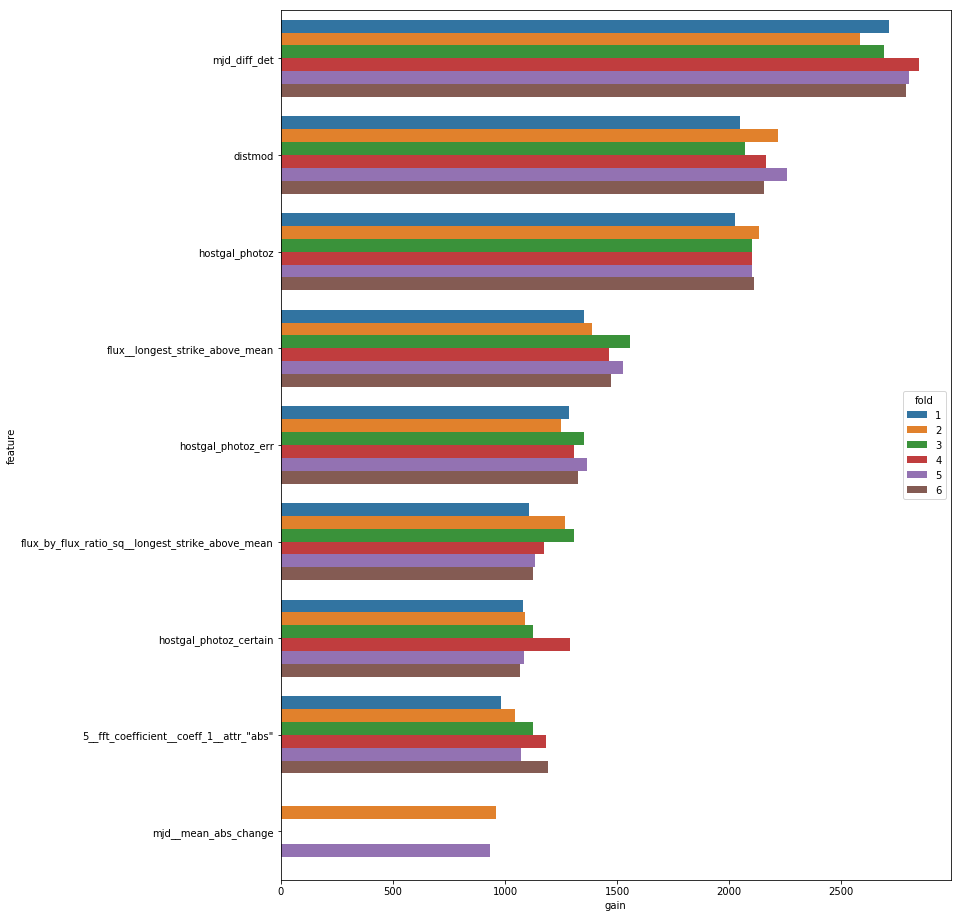

In [19]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).head(50), x='gain', y='feature', hue='fold', )
plt.show()

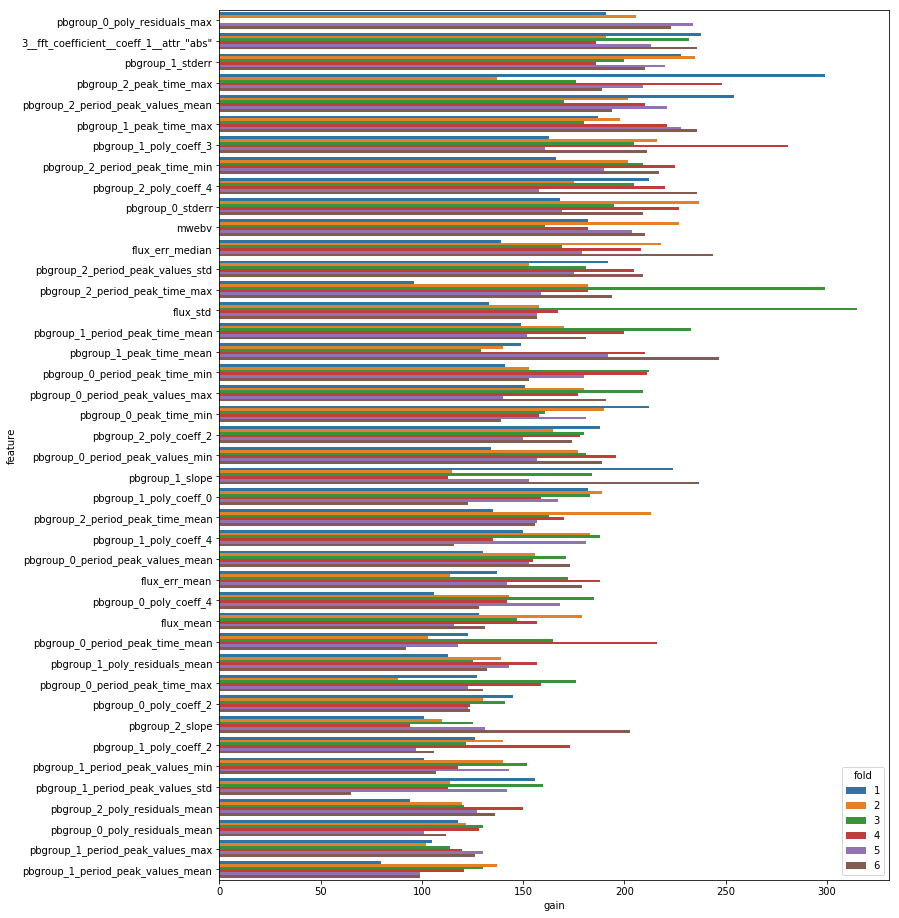

In [20]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False).tail(250), x='gain', y='feature', hue='fold', )
plt.show()

### Generate features for the test set

In [21]:
sorted_importances = importances.groupby('feature').mean().sort_values(by='mean_gain', ascending=False)

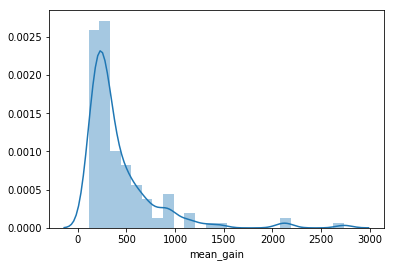

In [22]:
sns.distplot(sorted_importances['mean_gain'])

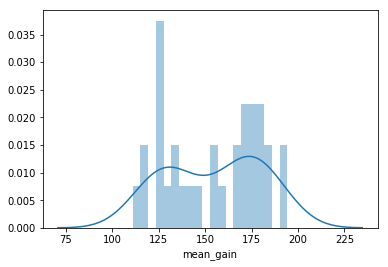

In [23]:
sns.distplot(sorted_importances[sorted_importances['mean_gain'] < 200.]['mean_gain'], bins=20)

In [24]:
new_features_to_drop = sorted_importances[sorted_importances['mean_gain'] < 100.].index.unique()

In [25]:
new_features_to_drop

Index([], dtype='object', name='feature')

### Featurize the test set

In [26]:
chunk_size_one_100 = 453653105 // 100 + 1
# chunk_size_one_100 = 1000001 // 100 + 1
chunk_size_one_100

4536532

In [37]:
from datetime import datetime
datetime.now()  # should take no more than 12hrs

datetime.datetime(2018, 12, 14, 20, 12, 17, 563401)

In [46]:
X1 = X.iloc[:4000].copy()
X2 = X.iloc[4000:].copy()

In [51]:
X.shape

(7848, 156)

In [50]:
pd.concat([X1,X2]).shape

(7848, 156)

In [ ]:
%%time
# should take 100x (time after 1st iteration)
featurize_test(
    featurize_configs={'aggs': aggs, 'fcp': fcp}, 
    n_jobs=16,
    meta_path='../../data/raw/test_set_metadata.csv',
    test_path='../../data/raw/test_set.csv',
    output_path='../../data/features/test-3band-series-models.csv',
    id_colname='object_id',
    chunks=chunk_size_one_100,  # alternatively: 5000000
)

In [39]:
print("Done.")

Done.
